# Discovering the KdV equation from data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from pysindy import FiniteDifference # Borrowing finite difference function from PySINDy 
from pysr import PySRRegressor

## Importing the Dataset

In [4]:
KdV_data = loadmat('./kdv_data.mat')

In [5]:
u = KdV_data['u']
x = KdV_data['x'].flatten()
t = KdV_data['t'].flatten()
dt = t[1] - t[0]
dx = x[1] - x[0]

Checking the shape of the data

In [6]:
print(' Number of time points:', t.shape, '\n Number of spatial points:', x.shape, '\n Shape of the u:', u.shape)

 Number of time points: (51,) 
 Number of spatial points: (401,) 
 Shape of the u: (51, 401)


Therefore, the data imported has the shape u(T,X), with T being time, and X being space.
You should also check that the time and space are indeed sampled at fixed frequency (open `t` and `x` to check!)

## Visualise

It is always a good idea to have a sanity check that the data make sense and see if there are potential challenges.

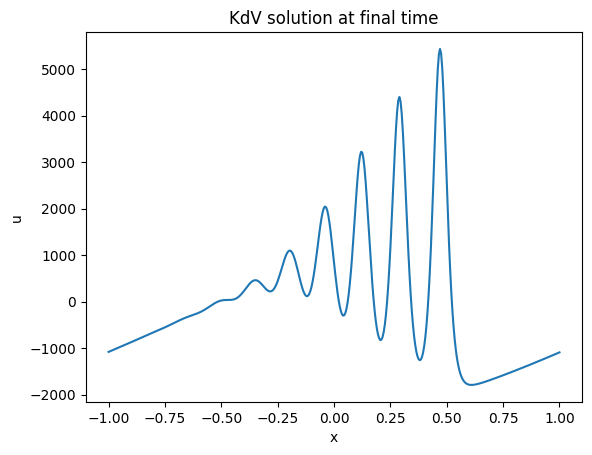

In [7]:
plt.plot(x,u[-1,:])
plt.xlabel('x')
plt.ylabel('u')
plt.title('KdV solution at final time')
plt.show()

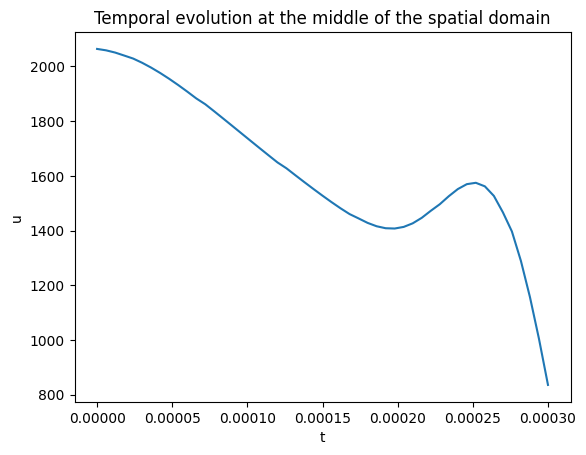

In [8]:
plt.plot(t,u[:,200])
plt.xlabel('t')
plt.ylabel('u')
plt.title('Temporal evolution at the middle of the spatial domain')
plt.show()

Text(0.5, 1.0, '$u(x, t)$')

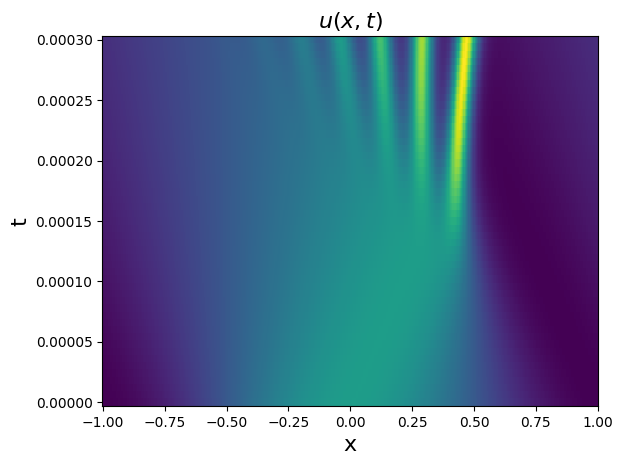

In [9]:
# Plot derivative results
plt.figure()
plt.pcolormesh(x, t, u)
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)


Things to look out for:
- What is the scale of time `t`, `x`, and `u`?
    - That gives you a sense of the expected scale of the derivatives. 
    - Do you need to rescale things to make the learning easier?
- What's the signal time scale and length scale? 
    - Am I sampling frequently enough (e.g. above Nyquist frequency)?
- If the signal is noisy, can you at least make out the lengthscale and time scale? That will help you choose the right derivative scheme. For example, if it's too noisy but frequently sampled, may be you want to use weak formulation to filter the frequency signal.

## Learning from analytically derived $\partial u / \partial t$ and $\partial u / \partial x$ (The easier option)
To get started, let's do the easier option of making use of the (noiseless) analytically derived spatial and temporal derivatives. 

Note that normally, derivatives are not provided as part of the dataset. These providede derivatives are purely for demonstration of the package.

In [11]:
u_x = KdV_data['u_x'] # Already flattened and ordered in columns of features
u_t = KdV_data['u_t'] # Already flattened 

print('Data Loading and success\n')

model_real = PySRRegressor(binary_operators=["+", "*" ], 
                                complexity_of_operators={"+": 5}, 
                                nested_constraints={"*": {"*" : 3} }, 
                                maxsize = 35, 
                                batching=True,
                                populations=300,
                                population_size=57,
                                ncyclesperiteration = 1000,
                                )
model_real.fit(u_x,np.real(u_t))
print('KdV Train Test \n')
print(model_real.get_best().equation)

/home/lloydfung/repos/kdv_discover/.venv/lib/python3.12/site-packages/pysr/sr.py:1036: FutureWarning: `ncyclesperiteration` has been renamed to `ncycles_per_iteration` in PySRRegressor. Please use that instead.
  warnings.warn(
/home/lloydfung/repos/kdv_discover/.venv/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...


Data Loading and success



[ Info: Started!



Expressions evaluated per second: 7.180e+03
Progress: 259 / 30000 total iterations (0.863%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.286e+20  0.000e+00  y = 3.3992
3           6.302e+19  -0.000e+00  y = x₂ * -13337
5           4.159e+19  -0.000e+00  y = (-1.9678 * x₂) * x₀
7           2.693e+19  -0.000e+00  y = 1.4791 * ((x₀ * -1.8999) * x₂)
9           2.464e+19  -0.000e+00  y = (2.2912 * ((x₀ * x₂) * -0.62494)) * 2.2912
11          9.655e+05  1.386e+00  y = ((x₀ * x₀) * x₀) + 0.16649
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.1

[ Info: Final population:
[ Info: Results saved to:


KdV Train Test 

x0 * (x0 * x0)
  - outputs/20251002_122741_2pp51T/hall_of_fame.csv


## Generating the derivatives

In [12]:
# Time and space derivatives
ut = FiniteDifference(d=1, axis=0)._differentiate(u, dt)
ux = FiniteDifference(d=1, axis=1)._differentiate(u, dx)
uxx = FiniteDifference(d=2, axis=1)._differentiate(u, dx)
uxxx = FiniteDifference(d=3, axis=1)._differentiate(u, dx)
uxxxx = FiniteDifference(d=4, axis=1)._differentiate(u, dx)


## Invoke PySINDy to learn

In [10]:
# Define the library
#   Here we use the standard PDE library, which computes the derivatives automatically (using finite difference by default)
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False), 
    derivative_order=3, # up to third order spatial derivatives
    spatial_grid=x
)
# Alternatively, we can also use weak formulation to compute the derivatives, which is more robust to noise
# X, T = np.meshgrid(x, t)
# XT = np.asarray([X, T]).T
# pde_lib = ps.WeakPDELibrary(
#     function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
#     derivative_order=3,
#     spatiotemporal_grid=XT,
# )

# Define the optimizer 
#   Think about why is the threshold so large? 
#   What is the order of magnitude of ut compared to normalised u.ux or uxxx?)
#   What does "normalize_columns=True" do?
optimizer = ps.STLSQ(threshold=1e9, normalize_columns=True)

# Define the SINDy model
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

# Reshape the data and fit the model
#   Note that we need to transpose u and reshape u to have the shape (T, X, D)
#   Here D is the number of dimensions of the target, which is 1 in this case.
model_data = u.T.reshape(u.shape[1],u.shape[0],1)

# Call the regression algorithm
model.fit(model_data, t=dt, feature_names=['u'])
# If you want to use smoothed finite difference to compute ut, use `x_dot` argument to pass in the precomputed du/dt
# model.fit(model_data, t=dt, x_dot = ut_smooth.T.reshape(ut.shape[1],ut.shape[0],1), feature_names=['u'])

# print identified PDE
print("Identified PDE: ")
model.print()

Identified PDE: 
(u)' = -1.017 u_111 + -0.995 uu_1


Try to play around with different 
- PDE library, 
- deriviative method, 
- precomputed du/dt, 
- normalization and 
- threshold parameter.

Which combo of hyperparameters give you better/worse result? Why?
